### Importando os pacotes

In [2]:
import pandas as pd 
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.svm import SVC
from xgboost import XGBClassifier
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.metrics import accuracy_score
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

### Carregando os Dados

In [3]:
df = pd.read_csv('dataset.csv')

In [4]:
df.shape

(1042, 2)

In [5]:
df.head()

,sentence,category
0,"Auxílio-Doença Previdenciário, Benefícios em E...",orgão público
1,"PAGAR TODAS AS CONTAS EM ATRASO R$1.290,90.",finanças
2,Então encontraremos na próxima aula.,educação
3,Veja os resultados da categoria de ofertas do ...,indústrias
4,"Além disso, a embalagem é reutilizável e 100% ...","indústrias,varejo"


In [6]:
# Criando colunas das categorias com 0 e 1 
df['financa'] = np.where(df['category'].str.contains('finanças'), 1, 0)
df['educacao'] = np.where(df['category'].str.contains('educação'), 1, 0)
df['industria'] = np.where(df['category'].str.contains('indústrias'), 1, 0) 
df['varejo'] = np.where(df['category'].str.contains('varejo'), 1, 0) 
df['orgao_publico'] = np.where(df['category'].str.contains('orgão público'), 1, 0)

In [7]:
# Descarta a coluna category
df.drop("category", axis=1, inplace=True)

In [8]:
df.head()

,sentence,financa,educacao,industria,varejo,orgao_publico
0,"Auxílio-Doença Previdenciário, Benefícios em E...",0,0,0,0,1
1,"PAGAR TODAS AS CONTAS EM ATRASO R$1.290,90.",1,0,0,0,0
2,Então encontraremos na próxima aula.,0,1,0,0,0
3,Veja os resultados da categoria de ofertas do ...,0,0,1,0,0
4,"Além disso, a embalagem é reutilizável e 100% ...",0,0,1,1,0


### Análises

In [9]:
def bar_values(ax, labels):
    
    rects = ax.patches

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=15)

    return ax

In [10]:
def plot_histogram_labels(title, x_label, y_label, labels, hue_label=None, data=None):

    sns.set(style='whitegrid', font_scale=2)
    plt.figure(figsize=(14, 8))

    ax = sns.barplot(x_label, y_label, hue=hue_label, data=data, palette='coolwarm')

    plt.title(title, fontsize=20)
    plt.xlabel('')
    plt.ylabel('Comentários', fontsize=15)

    bar_values(ax, labels)

    plt.show()

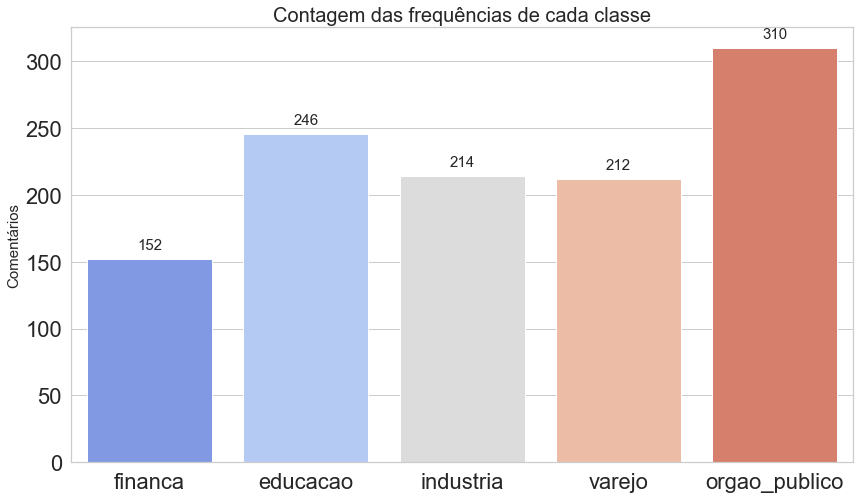

In [11]:
labels = list(df.iloc[:, 1:].columns.values)
labels_count = df[labels].sum().values

plot_histogram_labels(title='Contagem das frequências de cada classe', x_label=labels, y_label=labels_count,
                      labels=labels_count)

In [12]:
def word_cloud_text(text):

    cmap = plt.cm.coolwarm

    cloud = WordCloud(
        stopwords=STOPWORDS,
        background_color='white',
        colormap=cmap,
        collocations=False,
        width=2500,
        height=1800).generate(" ".join(text))

    return cloud

In [13]:
def plot_cloud_text(cloud, sub, nrows=False, ncols=False, index=False):

    if(nrows):
        plt.subplot(nrows, ncols, index)
        plt.axis('off')
        plt.title(sub, fontsize=20)
        plt.imshow(cloud);
    else:
        plt.axis('off')
        plt.title(sub, fontsize=20)
        plt.imshow(cloud);

In [14]:
comments = df['sentence'].values

DICT_LABELS = {
    'financa': 0,
    'educacao': 0,
    'industria': 0,
    'varejo': 0,
    'orgao_publico': 0,
}

for l in DICT_LABELS:
    DICT_LABELS[l] = df[df[l] == 0]['sentence'].values

cloud_comments = word_cloud_text(comments)

cloud_financa = word_cloud_text(DICT_LABELS['financa'])
cloud_educacao = word_cloud_text(DICT_LABELS['educacao'])
cloud_industria = word_cloud_text(DICT_LABELS['industria'])
cloud_varejo = word_cloud_text(DICT_LABELS['varejo'])
cloud_opublico = word_cloud_text(DICT_LABELS['orgao_publico'])

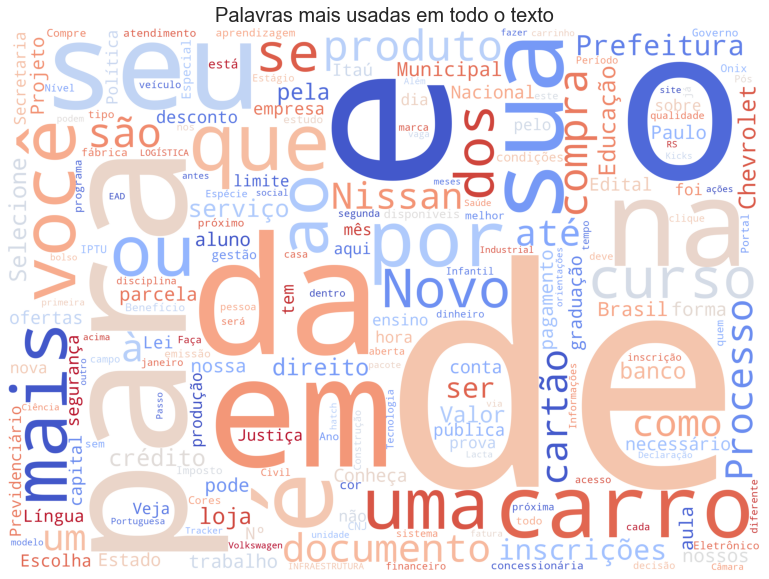

In [15]:
plt.figure(figsize=(20, 10))
plot_cloud_text(cloud_comments, 'Palavras mais usadas em todo o texto')

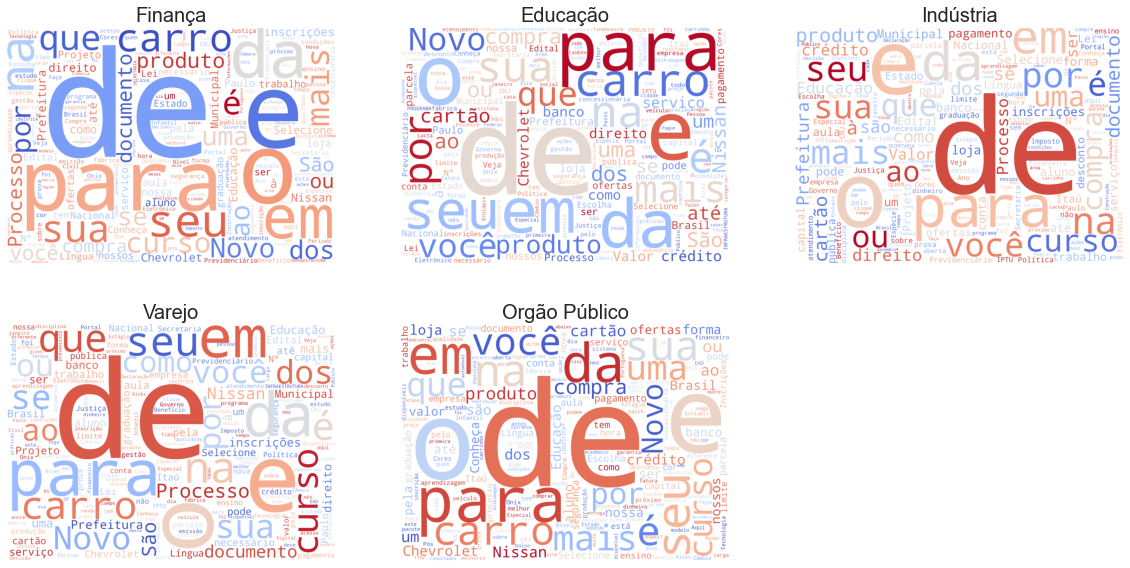

In [16]:
plt.figure(figsize=(20, 10))

plot_cloud_text(cloud_financa, 'Finança', nrows=2, ncols=3, index=1)
plot_cloud_text(cloud_educacao, 'Educação', nrows=2, ncols=3, index=2)
plot_cloud_text(cloud_industria, 'Indústria', nrows=2, ncols=3, index=3)
plot_cloud_text(cloud_varejo, 'Varejo', nrows=2, ncols=3, index=4)
plot_cloud_text(cloud_opublico, 'Orgão Público', nrows=2, ncols=3, index=5)

plt.show()

In [118]:
df.describe()

,financa,educacao,industria,varejo,orgao_publico
count,1042.000000,1042.000000,1042.000000,1042.000000,1042.000000
mean,0.145873,0.236084,0.205374,0.203455,0.297505
std,0.353149,0.424879,0.404169,0.402761,0.457380
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


### Correlação

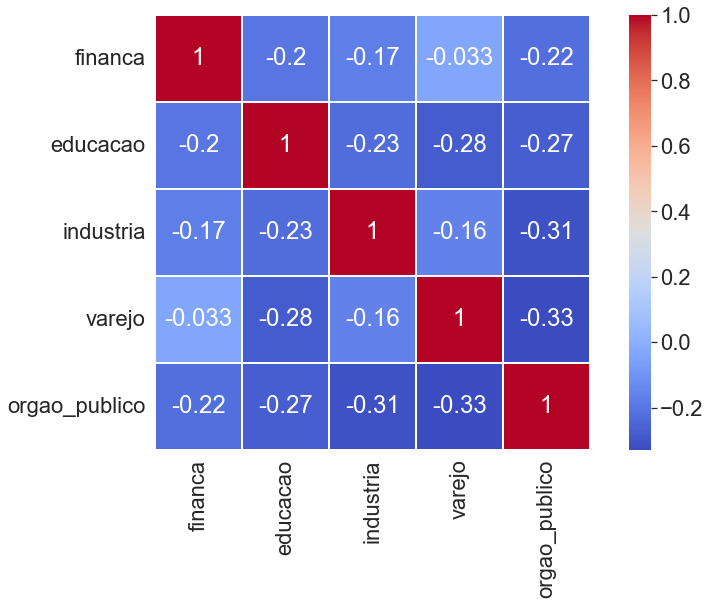

In [119]:
data = df[labels]

colormap = plt.cm.coolwarm
plt.figure(figsize = (14, 8))

sns.heatmap(data.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, 
            linecolor='white', annot=True);

### Pré-processamento

In [120]:
# Função para limpar as frases
def limpar_text(text):
    
    text = text.encode('ascii', errors = 'ignore').decode() #Decodificando caracteres em ASCII
    text = text.lower() #Apenas caracteres minúsculos
    text = re.sub(r'http\S+', ' ', text) #Evitando links
    #Evitando contrações
    text = re.sub(r'#+', ' ', text)
    text = re.sub(r'@[A-Za-z0-9]+', ' ', text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = text.strip(' ') #Removendo espaços do começo e fim 
    
    return text

In [121]:
# Utilizando dicionário do pacote NLTK
tokenizer = nltk.data.load('tokenizers/punkt/portuguese.pickle')

In [122]:
# Função para remover as stopwords
def remove_stopwords(text):
    # setando as stopwords para português
    stop_words = set(stopwords.words('portuguese'))
    
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    
    return filtered_sentence

In [123]:
# Limpando o texto
df['text_tokens'] = df['sentence'].apply(limpar_text)

# Removendo as stopwords e tokenizando o texto
df['text_tokens'] = df['text_tokens'].apply(remove_stopwords)

df[['sentence', 'text_tokens']].head()

,sentence,text_tokens
0,"Auxílio-Doença Previdenciário, Benefícios em E...","[auxlio, doena, previdencirio, benefcios, espc..."
1,"PAGAR TODAS AS CONTAS EM ATRASO R$1.290,90.","[pagar, todas, contas, atraso, r]"
2,Então encontraremos na próxima aula.,"[ento, encontraremos, prxima, aula]"
3,Veja os resultados da categoria de ofertas do ...,"[veja, resultados, categoria, ofertas, novo, m..."
4,"Além disso, a embalagem é reutilizável e 100% ...","[alm, disso, embalagem, reutilizvel, reciclvel]"


### Separação em conjuntos de treino e teste estratificado

In [124]:
text_tokens = []

for vet in df['text_tokens'].values:
    text_tokens.extend(vet)

# Palavras do dataset
num_words_vocab = len((list(set(text_tokens))))

print('Quantidade de palavras presentes no texto: {}'.format(len(text_tokens)))
print('Tamanho do vocabulário (palavras sem repetição): {}\n'.format(num_words_vocab))

Quantidade de palavras presentes no texto: 6876
Tamanho do vocabulário (palavras sem repetição): 1832



In [125]:
# Transforma cada texto em uma sequência de números inteiros (cada número inteiro é o índice de um token em um dicionário.
tok = Tokenizer(num_words=num_words_vocab)
tok.fit_on_texts(df['text_tokens'].values)

df['X'] = tok.texts_to_sequences(df['text_tokens'])
 
df[['sentence', 'text_tokens', 'X']].head()

,sentence,text_tokens,X
0,"Auxílio-Doença Previdenciário, Benefícios em E...","[auxlio, doena, previdencirio, benefcios, espc...","[293, 294, 48, 89, 90, 29, 48]"
1,"PAGAR TODAS AS CONTAS EM ATRASO R$1.290,90.","[pagar, todas, contas, atraso, r]","[124, 191, 192, 615, 1]"
2,Então encontraremos na próxima aula.,"[ento, encontraremos, prxima, aula]","[295, 616, 91, 62]"
3,Veja os resultados da categoria de ofertas do ...,"[veja, resultados, categoria, ofertas, novo, m...","[49, 193, 296, 30, 4, 617, 10, 125]"
4,"Além disso, a embalagem é reutilizável e 100% ...","[alm, disso, embalagem, reutilizvel, reciclvel]","[126, 618, 297, 298, 299]"


In [126]:
df['num_words'] = df['text_tokens'].apply(lambda x : len(x))

max_num_words = df['num_words'].max()

df[['sentence', 'text_tokens', 'num_words']].nlargest(5, 'num_words')

,sentence,text_tokens,num_words
28,"As marcas BMW, CHEVROLET, RENAULT, VOLKSWAGEN...","[marcas, bmw, chevrolet, renault, volkswagen, ...",15
549,"As marcas BMW, CHEVROLET, RENAULT, VOLKSWAGEN...","[marcas, bmw, chevrolet, renault, volkswagen, ...",15
99,Cada trabalho acadêmico deve ser organizado de...,"[cada, trabalho, acadmico, deve, organizado, d...",14
210,Para se enquadrar nesta categoria é necessário...,"[enquadrar, nesta, categoria, necessrio, apres...",14
362,As ofertas são diferentes para cada localizaçã...,"[ofertas, so, diferentes, cada, localizao, sai...",14


In [127]:
X = pad_sequences(maxlen=max_num_words, sequences=df['X'], value=0, padding='post', truncating='post')
y = df[labels].values

print('Dimensão do X: {}'.format(X.shape))
print('Dimensão do y: {}'.format(y.shape))

Dimensão do X: (1042, 15)
Dimensão do y: (1042, 5)


In [128]:
df

,sentence,financa,educacao,industria,varejo,orgao_publico,text_tokens,X,num_words
0,"Auxílio-Doença Previdenciário, Benefícios em E...",0,0,0,0,1,"[auxlio, doena, previdencirio, benefcios, espc...","[293, 294, 48, 89, 90, 29, 48]",7
1,"PAGAR TODAS AS CONTAS EM ATRASO R$1.290,90.",1,0,0,0,0,"[pagar, todas, contas, atraso, r]","[124, 191, 192, 615, 1]",5
2,Então encontraremos na próxima aula.,0,1,0,0,0,"[ento, encontraremos, prxima, aula]","[295, 616, 91, 62]",4
3,Veja os resultados da categoria de ofertas do ...,0,0,1,0,0,"[veja, resultados, categoria, ofertas, novo, m...","[49, 193, 296, 30, 4, 617, 10, 125]",8
4,"Além disso, a embalagem é reutilizável e 100% ...",0,0,1,1,0,"[alm, disso, embalagem, reutilizvel, reciclvel]","[126, 618, 297, 298, 299]",5
...,...,...,...,...,...,...,...,...,...
1037,"Selecione o local de estudo, curso sem encontr...",0,1,0,0,0,"[selecione, local, estudo, curso, encontros, p...","[18, 286, 491, 9, 1822, 183]",6
1038,ESTUDANTES DA REDE MUNICIPAL VOLTAM ÀS AULAS E...,0,1,0,0,1,"[estudantes, rede, municipal, voltam, s, aulas...","[1823, 457, 21, 1824, 20, 135, 600]",7
1039,Empresas e órgãos públicos,0,0,0,0,1,"[empresas, rgos, pblicos]","[99, 1825, 1826]",3
1040,DGE – Departamento de Gestão Estratégica Metas...,0,0,0,0,1,"[dge, departamento, gesto, estratgica, metas, ...","[1827, 1828, 66, 1829, 213, 214, 75, 76, 534, ...",12


In [174]:
# Divisão de Treino e Teste
np.random.seed(42)
X_train, y_train, X_test, y_test = iterative_train_test_split(X, y, test_size=0.4)

In [175]:
(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(((624, 15), (624, 5)), ((418, 15), (418, 5)))

In [176]:
def conta_ocorrencia(matrix_y):
    
    CLASSES = {
        'financa': 0,
        'educacao': 0,
        'industria': 0,
        'varejo': 0,
        'orgao_publico': 0,
    }
    
    for vet in matrix_y.values:
        for value, label in zip(vet, CLASSES):
            CLASSES[label] += int(value)

    return CLASSES

def calcula_proporcao(DICT_CLASSES, labels_names):
    proportions = {}
    
    for label in labels_names:
        prop = DICT_CLASSES[label]/sum(DICT_CLASSES.values())
        proportions.update({label: prop})
        
    df = pd.DataFrame([proportions])

    return df

def result_prop(data, y_train, y_test):
    
    data = conta_ocorrencia(data)
    train = conta_ocorrencia(y_train)
    test = conta_ocorrencia(y_test)

    prop_data = calcula_proporcao(data, labels)
    prop_train = calcula_proporcao(train, labels)
    prop_test = calcula_proporcao(test, labels)

    df = pd.concat([prop_data, prop_train, prop_test], ignore_index=True)
    df.rename(index={
      0: 'dataset', 
      1: 'train_set', 
      2: 'test_set'}, inplace=True)

    return df

In [177]:
# Contagem de ocorrência
classif_data = conta_ocorrencia(df[labels])
classif_train = conta_ocorrencia(pd.DataFrame(y_train))
classif_test = conta_ocorrencia(pd.DataFrame(y_test))

In [178]:
classif_train_test = list(classif_data.values())
classif_train_test.extend(list(classif_train.values()))
classif_train_test.extend(list(classif_test.values()))

inform_train_test = pd.DataFrame(columns=['labels', 'ocorr', 'set'])

for label, value in zip((labels*3), classif_train_test):
    inform_train_test = inform_train_test.append({
        'labels': label,
        'ocorr': value
  }, ignore_index=True)

inform_train_test['set'][0:5] = 'data'
inform_train_test['set'][5:10] = 'train'
inform_train_test['set'][10:15] = 'test'

inform_train_test

,labels,ocorr,set
0,financa,152,data
1,educacao,246,data
2,industria,214,data
3,varejo,212,data
4,orgao_publico,310,data
5,financa,91,train
6,educacao,148,train
7,industria,128,train
8,varejo,127,train
9,orgao_publico,186,train


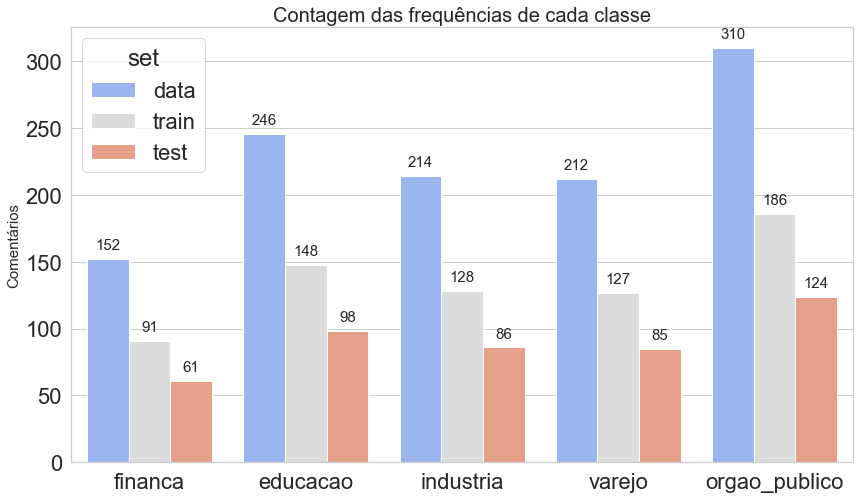

In [179]:
plot_histogram_labels('Contagem das frequências de cada classe', x_label='labels', y_label='ocorr',
                      labels=classif_train_test, hue_label='set', data=inform_train_test)

In [180]:
# Proporções
prop_data = calcula_proporcao(classif_data, labels)
prop_train = calcula_proporcao(classif_train, labels)
prop_test = calcula_proporcao(classif_test, labels)

result_prop = pd.concat([prop_data, prop_train, prop_test], ignore_index=True)
result_prop.rename(index={
    0: 'dataset', 
    1: 'train_set', 
    2: 'test_set'}, inplace=True)

result_prop

,financa,educacao,industria,varejo,orgao_publico
dataset,0.134039,0.216931,0.188713,0.186949,0.273369
train_set,0.133824,0.217647,0.188235,0.186765,0.273529
test_set,0.134361,0.215859,0.189427,0.187225,0.273128


In [181]:
# Criando o modelo, treinando, fazendo previsões e verificando a acurácia
BR = BinaryRelevance(classifier=SVC(), require_dense=[False, True])

BR.fit(X_train, y_train)

y_pred = BR.predict(X_test)

print("Acurácia = ", accuracy_score(y_test, y_pred))

Acurácia =  0.03588516746411483


In [182]:
CC = ClassifierChain(classifier=XGBClassifier(), require_dense=[False, True])

CC.fit(X_train, y_train)

y_pred = CC.predict(X_test)

print("Acurácia = ", accuracy_score(y_test, y_pred))

Acurácia =  0.8660287081339713


In [183]:
LP = LabelPowerset(classifier=RandomForestClassifier(n_estimators=100), require_dense=[False, True])

LP.fit(X_train, y_train)

y_pred = LP.predict(X_test)

print("Acurácia = ", accuracy_score(y_test, y_pred))

Acurácia =  0.8421052631578947


In [201]:
print(y_test)

[[0 0 0 0 1]
 [1 0 0 0 0]
 [0 0 1 0 0]
 ...
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 1 0]]


In [260]:
i = 0
for valor in y_pred:
    teste= str(y_pred[i])
    print(y_test[i],' ',teste[-4])
    i = i+1

[0 0 0 0 1]   4
[1 0 0 0 0]   2
[0 0 1 0 0]   2
[0 1 0 0 0]   1
[0 0 0 1 0]   3
[0 0 0 1 0]   3
[1 0 0 0 0]   3
[0 0 0 1 0]   3
[0 1 0 0 0]   1
[0 1 0 0 0]   1
[0 0 1 0 0]   2
[0 0 0 1 0]   3
[0 0 0 0 1]   4
[0 0 1 0 0]   2
[1 0 0 0 0]   3
[0 1 0 0 0]   1
[1 0 0 1 0]   3
[1 0 0 0 0]   1
[0 1 0 0 0]   1
[0 0 0 0 1]   4
[0 1 0 0 0]   1
[0 1 0 0 0]   1
[0 0 1 0 0]   2
[1 0 0 0 0]   2
[0 0 1 0 0]   2
[0 0 0 1 0]   3
[0 0 0 0 1]   4
[0 0 0 1 0]   3
[0 1 0 0 0]   1
[0 1 0 0 0]   1
[0 1 0 0 0]   1
[1 0 0 1 0]   3
[0 0 1 0 0]   2
[0 1 0 0 0]   1
[1 0 0 0 0]   4
[0 0 0 1 0]   3
[0 0 0 0 1]   1
[0 1 0 0 1]   4
[0 0 1 0 0]   2
[0 0 1 1 0]   2
[0 0 0 0 1]   4
[1 0 0 0 0]   1
[0 1 0 0 0]   1
[0 0 0 1 0]   3
[0 0 0 1 0]   3
[1 0 0 1 0]   3
[0 0 0 0 1]   4
[0 0 1 0 0]   2
[0 0 0 0 1]   4
[0 0 0 1 0]   3
[0 1 0 0 0]   1
[1 0 0 0 1]   4
[0 0 0 1 0]   3
[0 0 0 0 1]   4
[0 0 1 0 0]   2
[0 1 0 0 0]   1
[0 0 0 0 1]   1
[0 0 0 0 1]   4
[0 0 0 0 1]   1
[1 0 0 0 0]   1
[0 0 1 0 0]   2
[0 0 0 0 1]   4
[0 1 0 0